# Optimal Resource Planning
## Author: Snigdhayan Mahanta
Suppose a portfolio manager has 100 possible projects to choose from and 10 disciplines to execute the selected projects. The disciplines in turn have fixed human resources allocated to them limiting the total number of labor hours available per discipline. Let us assume that the portfolio manager has the following information available for decision-making:

1. A numerical ranking of the projects according to some uniform scale (e.g., net present value)
2. For each project a resource request per discipine (number of labor hours)

What would be the optimal resource planning for the projects? For this purpose one can define an objective function to optimize the overall business value and then use `solver` to find an optimum solution. In what follows I performed a simulation and demonstrated how the results can fluctuate based on slightly different boundary conditions. 

REMARK: This approach makes an assumption that there is a linear correlation between the resource allocation of a project and the associated business value. This assumption is highly questionable in practice. The optimization framework can be enhanced to incorporate more information into the model and eliminate this questionable assumption. 

CAUTION: If the numerical rankings do not correspond to the relative expected project ROIs, then the computed optimum values below do not have a clear correlation with the overall portfolio values. Nevertheless, this methodology can be applied to allocate resources to optimize the overall business value from the projects.

In [1]:
from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [2]:
# Define the function to specify the linear optimization problem as a matrix multiplication
def create_data(shape):
    array1 = np.random.randint(low = 0, high = 2000, size = shape) 
    matrix_coeffs = array1.tolist() # labor hour request per discipline (row) per project (column)
    constraints = np.random.randint(low = 100, high = 500, size = shape[0]) 
    constraints = constraints.tolist() # total available labor hours per discipline
    array2 = np.random.randint(low = 0, high = 100, size = shape[1]) 
    objective_coeffs = [(x*np.ones(shape[0])).tolist() for x in array2]
    objective_coeffs = list(map(list, zip(*objective_coeffs))) # coefficients of objective function
    ranking = {} 
    for i in range(1, len(array2)+1):
        ranking["Project_"+str(i)] = array2[i-1]
    ranking = dict(sorted(ranking.items(), key=lambda item: item[1], reverse = True)) # project ranking
    
    # Optimization parameters
    data = {}
    data['matrix_coeffs'] = matrix_coeffs
    data['constraints'] = constraints
    data['objective_coeffs'] = objective_coeffs

    # Other attributes
    data['n_constraints'] = len(constraints)
    data['n_rows'] = shape[0] # number of disciplines
    data['n_columns'] = shape[1] # number of projects
    data['ranking'] = ranking
    
    return data

In [3]:
# Create dataframe of the requested labor hours per project per discipline
def proj_disc_request(data):
    projects = ["Project_"+str(i+1) for i in range(data['n_columns'])]
    disciplines = ["Discipline_"+str(i+1) for i in range(data['n_rows'])]
    df = pd.DataFrame(data['matrix_coeffs'], columns=projects)
    df.insert(0, "Disciplines", disciplines)
    df['Total Available Labor Hours'] = data['constraints']
    return df

In [4]:
# Create a small sample dataset of the requested labor hours per project per discipline
sample_dataset = create_data((3,5)) # 3 disciplines and 5 projects
df = proj_disc_request(sample_dataset)
df

,Disciplines,Project_1,Project_2,Project_3,Project_4,Project_5,Total Available Labor Hours
0,Discipline_1,1268,179,1905,188,842,162
1,Discipline_2,1561,205,883,1666,1953,234
2,Discipline_3,850,1528,592,1841,68,386


In [5]:
# Take a look at the project ranking (sorted by numerical ranking values)
sample_dataset['ranking']

{'Project_4': 58,
 'Project_5': 50,
 'Project_2': 35,
 'Project_1': 14,
 'Project_3': 3}

In [6]:
# Take a look at the objective coefficients
sample_dataset['objective_coeffs']

[[14.0, 35.0, 3.0, 58.0, 50.0],
 [14.0, 35.0, 3.0, 58.0, 50.0],
 [14.0, 35.0, 3.0, 58.0, 50.0]]

## Optimization Strategy
I am going to solve for the optimal fractional resource allocation based on the resource request structure as above. For each discipline and each project there will be a decision variable that will solve for the fraction of the requested resource to be allocated. Hence the total number of decision variables is the product of the number of projects and the number of disciplines. The objective function will be a linear combination of the decision variables and the objective coefficients that are determined by the project rankings. For simplicity, I assigned the same objective coefficient to decision variables that correspond to the same project (observe that the columns in the above cell outout have the same value).

In [7]:
# Define the optimization function; use the 'verbose' parameter to print the verbose result
def solve(data, verbose = 0):
    solver = pywraplp.Solver.CreateSolver('GLOP') # Create the linear solver with the GLOP backend
    # solver = pywraplp.Solver.CreateSolver('SCIP') # Create the mixed-integer programming solver with the SCIP backend
    infinity = solver.infinity()
    x = {}
    for i in range(data['n_rows']):
        for j in range(data['n_columns']):
            x[(i, j)] = solver.NumVar(0, 1, 'x_%i_%i' % (i, j)) # each decision variable is a fraction between 0 and 1
    # print('Number of variables =', solver.NumVariables())

    for i in range(data['n_rows']):
        constraint = solver.RowConstraint(0, data['constraints'][i], '')
        for j in range(data['n_columns']):
            constraint.SetCoefficient(x[(i,j)], data['matrix_coeffs'][i][j])
    # print('Number of constraints =', solver.NumConstraints())

    objective = solver.Objective() # solve for the fraction of the requested resource that is actually allocated
    for i in range(data['n_rows']):
        for j in range(data['n_columns']):
            objective.SetCoefficient(x[(i,j)], data['objective_coeffs'][i][j])
            objective.SetMaximization()

    status = solver.Solve()
    portfolio_resource = 0
    optimum = -1
    solution_values = [[1 for j in range(data['n_columns'])] for i in range(data['n_rows'])]
    resource_allocations = [[1 for j in range(data['n_columns'])] for i in range(data['n_rows'])]
    if verbose == 1 and status == pywraplp.Solver.OPTIMAL:
        print(F'Overall optimum value = {round(solver.Objective().Value(), 2)}\n')
        portfolio_resource = round(sum(data['constraints']), 2)
        print(F'Overall portfolio resource = {portfolio_resource}\n')
        for i in range(data['n_rows']):
            for j in range(data['n_columns']):
                if x[(i,j)].solution_value() != 0: 
                    print(F'Discipline {i+1} - Project {j+1} Fraction Allocation = {round(x[(i,j)].solution_value(), 2)}\n')
        
        # print(F'Problem solved in %f milliseconds {round(solver.wall_time(), 2)}')
        # print(F'Problem solved in %d iterations {solver.iterations()}')
        # print(F'Problem solved in %d branch-and-bound nodes {solver.nodes()}')
        
    if verbose == 1 and status != pywraplp.Solver.OPTIMAL:
        print(F'The problem does not have an optimal solution.')
            
    if verbose == 0 and status == pywraplp.Solver.OPTIMAL:
        selected_projects = []
        optimum = solver.Objective().Value()
        portfolio_resource = sum(data['constraints'])
        for i in range(data['n_rows']):
            for j in range(data['n_columns']):
                if x[(i,j)].solution_value() != 0: selected_projects.append(j)
                solution_values[i][j] = solution_values[i][j]*x[(i,j)].solution_value()
                resource_allocations[i][j] = data['matrix_coeffs'][i][j]*solution_values[i][j]
        return optimum, portfolio_resource, solution_values, resource_allocations, list(set(selected_projects))
    
    if verbose == 0 and status != pywraplp.Solver.OPTIMAL:
        selected_projects = []
        portfolio_resource = sum(data['constraints'])
        return optimum, portfolio_resource, solution_values, resource_allocations, list(set(selected_projects))

In [8]:
# Define the simulation function
def simulate(shape, n_trials):
    optimum_values = []
    portfolio_resources = []
    resource_allocation_list = []
    selected_project_list = []
    unsolvable_trials = 0
    
    for i in range(n_trials):
        data = create_data(shape)
        optimum, portfolio_resource, solution_values, resource_allocations, selected_projects = solve(data, verbose = 0)
        if optimum == -1: unsolvable_trials += 1
        optimum_values.append(optimum)
        portfolio_resources.append(portfolio_resource)
        resource_allocation_list.append(resource_allocations)
        selected_project_list.append(selected_projects)
    return optimum_values, portfolio_resources, unsolvable_trials, resource_allocation_list, selected_project_list

In [9]:
# Define portfolio structure 
shape = (10, 100) # (number of disciplines, number of projects)

# Solve a sample problem - print optimum portfolio value, overall portfolio resource and non-zero project resource allocations
data = create_data(shape)
solve(data, verbose = 1)

Overall optimum value = 3139.64

Overall portfolio resource = 3400

Discipline 1 - Project 24 Fraction Allocation = 1.0

Discipline 1 - Project 34 Fraction Allocation = 0.4

Discipline 1 - Project 76 Fraction Allocation = 1.0

Discipline 1 - Project 83 Fraction Allocation = 1.0

Discipline 2 - Project 2 Fraction Allocation = 0.55

Discipline 2 - Project 7 Fraction Allocation = 1.0

Discipline 2 - Project 16 Fraction Allocation = 1.0

Discipline 2 - Project 68 Fraction Allocation = 1.0

Discipline 2 - Project 83 Fraction Allocation = 1.0

Discipline 2 - Project 93 Fraction Allocation = 1.0

Discipline 3 - Project 74 Fraction Allocation = 1.0

Discipline 3 - Project 75 Fraction Allocation = 1.0

Discipline 3 - Project 77 Fraction Allocation = 1.0

Discipline 3 - Project 82 Fraction Allocation = 0.69

Discipline 3 - Project 86 Fraction Allocation = 1.0

Discipline 4 - Project 1 Fraction Allocation = 1.0

Discipline 4 - Project 28 Fraction Allocation = 1.0

Discipline 4 - Project 45 Fracti

In [10]:
# Look at top 10 projects and their ranking values
all_projects = data['ranking'].items()
top_projects = dict(list(all_projects)[:10])
top_projects

{'Project_13': 99,
 'Project_33': 99,
 'Project_1': 98,
 'Project_22': 98,
 'Project_77': 98,
 'Project_8': 96,
 'Project_81': 93,
 'Project_34': 92,
 'Project_52': 92,
 'Project_67': 92}

In [11]:
# Define simulation parameter and run the simulation
n_trials = 100 # number of simulation trials
values, resources, unsolvable_trials, resource_allocation_list, selected_project_list = simulate(shape, n_trials)

In [12]:
# Print simulation overview
print(F'# Discipines = {shape[0]}')
print(F'# Projects = {shape[1]}')
print(F'# Simulation Trials = {n_trials}') 
print(F'# Unsolvable Trials = {unsolvable_trials}') 

# Discipines = 10
# Projects = 100
# Simulation Trials = 100
# Unsolvable Trials = 0


In [13]:
# Print the mean and the standard deviation of optimum portfolio values
print(F'Mean of Portfolio Values = {round(mean(values), 2)}')
print(F'Standard Deviation of Portfolio Values = {round(stdev(values), 2)}')

Mean of Portfolio Values = 2910.41
Standard Deviation of Portfolio Values = 342.38


In [14]:
# Print the mean and the standard deviation of overall portfolio resources
print(F'Mean of Portfolio Resources = {round(mean(resources), 2)}')
print(F'Standard Deviation of Portfolio Resources = {round(stdev(resources), 2)}')

Mean of Portfolio Resources = 2982.53
Standard Deviation of Portfolio Resources = 371.29


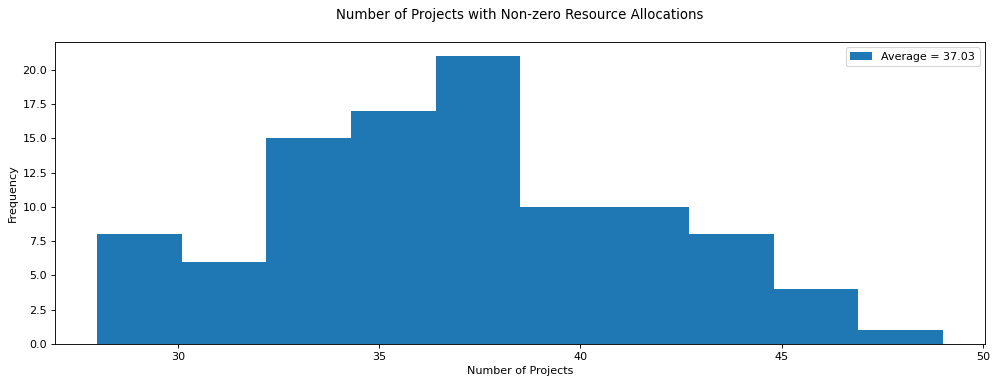

In [15]:
# Plot the histogram of the number of projects with non-zero resource allocations

# x-axis values 
x = range(n_trials)
# y-axis values
y =  [len(x) for x in selected_project_list]
average = sum(y)/len(y)

# Plot histogram
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.hist(y)

# x-axis name
plt.xlabel(F'Number of Projects')

# y-axis name
plt.ylabel(F'Frequency')

# Title and legends
plt.title(F'Number of Projects with Non-zero Resource Allocations\n')

legends = [F'Average = {average}']
plt.legend(legends, loc='upper right')

plt.show()

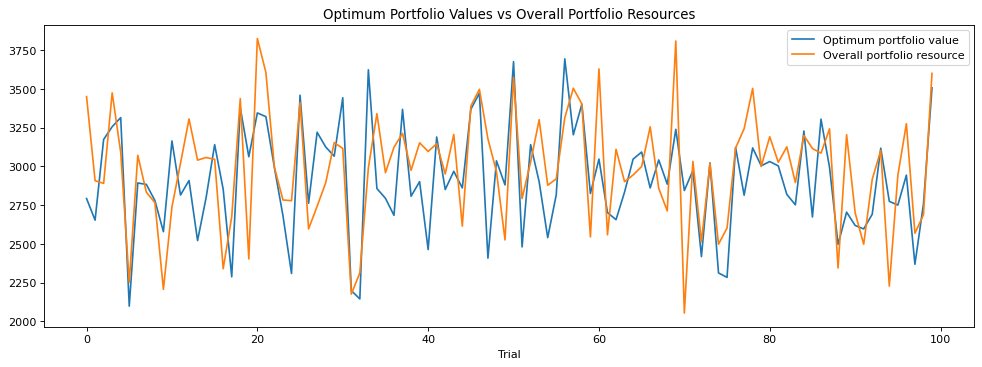

In [16]:
# Plot the optimum portfolio values and overall portfolio resources

# x-axis values 
x = range(n_trials)
# y-axis values 
y = values

# Plot the points 
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y)


# x-axis values 
x = range(n_trials)
# y-axis values 
y = resources

# Plot the points
plt.plot(x, y)

# x-axis name
plt.xlabel(F'Trial') 

# Title and legends
plt.title(F'Optimum Portfolio Values vs Overall Portfolio Resources')

legends = [F'Optimum portfolio value', F'Overall portfolio resource']
plt.legend(legends, loc='upper right')

plt.show()

As mentioned earlier, in this mathematical model the computed optimum values do not admit a clear monetary interpretation. Projects with fractional resource allocations (< 1) can be executed by acquiring the missing resources externally.